<a href="https://colab.research.google.com/github/JuliaOrtheden/COVID19-research-challenge/blob/master/DiseaseSpreading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
from enum import Enum
import random
import numpy as np
from matplotlib import colors
import copy
import time
from matplotlib import animation, rc
from IPython.display import HTML
from numpy.random import choice
import seaborn as sns

# State Class

In [3]:
class State(Enum):
  susceptible = "blue"
  infected = "red"
  recovered = "green" 

  def __str__(self):
    return str(self.value)


# Grid class

In [4]:
class Grid:
  def __init__ (self, x, y, beta):
    self.y = y
    self.x = x
    self.beta = beta
    self.grid = [[[] for j in range(y)] for i in range(x)] # Neccessary? Switch to recovered????
    self.grid_susceptible = [[[] for j in range(y)] for i in range(x)]
    self.grid_infected = [[[] for j in range(y)] for i in range(x)]

  def __getitem__(self, index):
    return self.grid[index]

  def __str__(self):
    print_grid = copy.copy(self.grid.grid_susceptible)

    for row in range(self.x):
      for col in range(self.y):
        position = self.grid.grid_susceptible[row][col]
        print(*position)
        if not position:
          agents_list = []
          for agent in position:
            #print(str(agent))
            agents_list.append(agent.current_state)
          print_grid[row][col] = agents_list
      

    return "" #return str(print_grid)

  def update_position(self, agent, toX, toY):
    self.grid[agent.current_x][agent.current_y].remove(agent)
    self.grid[toX][toY].append(agent)

    if agent.get_state() == State.susceptible:
      self.grid_susceptible[agent.current_x][agent.current_y].remove(agent)
      self.grid_susceptible[toX][toY].append(agent)
      # Check if there are infected agents on to-positions
      all_infected_agents_at_position = self.grid_infected[toX][toY]
      if len(all_infected_agents_at_position) is not 0:
        self.spread_disease(toX, toY)
    
    elif agent.get_state() == State.infected:
      self.grid_infected[agent.current_x][agent.current_y].remove(agent)
      self.grid_infected[toX][toY].append(agent)
      self.spread_disease(toX, toY)
      

  # Help function to infect all agents
  def infect_all_agents(self, x, y):
    all_agents_at_position = self.grid_susceptible[x][y]
    for agent in all_agents_at_position:
      agent.current_state = State.infected
      self.grid_infected[x][y].append(agent)
      self.grid_susceptible[x][y].remove(agent)

  # Help function to recover all agents 
  def recover_all_agents(self):
    for row in range(self.x):
      for col in range(self.y):
        all_agents_at_position = self.grid_infected[row][col]

        if len(all_agents_at_position) != 0:
          for agent in all_agents_at_position:
            is_recovered = agent.recover_agent()
            if is_recovered:
              self.grid_infected[row][col].remove(agent)

  # Spreads the disease if the random number is less than beta
  def spread_disease(self, x, y):
    rand = random.random()
    if rand < self.beta:
      self.infect_all_agents(x, y)


  def get_number_of_infected_agents(self):
    n_infected_agents = 0
    for row in range(self.x):
      for col in range(self.y):
        all_infected_agents_at_position = self.grid_infected[row][col]
        n_infected_agents += len(all_infected_agents_at_position)
    return n_infected_agents

  def get_number_of_susceptible_agents(self):
    n_susceptible_agents = 0
    for row in range(self.x):
      for col in range(self.y):
        all_susceptible_agents_at_position = self.grid_susceptible[row][col]
        n_susceptible_agents += len(all_susceptible_agents_at_position)
    return n_susceptible_agents

  def get_number_of_recovered_agents(self, total_number_of_agents, n_infected_agents, n_susceptible_agents):
    return total_number_of_agents - (n_infected_agents + n_susceptible_agents)

  


# Agent Class

In [5]:
class Agent:
  def __init__ (self, current_state, current_y, current_x, move_prob, gamma, grid):
    self.current_state = current_state
    self.current_y = current_y
    self.current_x = current_x
    self.move_prob = move_prob
    self.gamma = gamma
    self.grid = grid
    self.init_grid_position()

  def init_grid_position(self):
    self.grid[self.current_x][self.current_y].append(self)
    if self.get_state() == State.susceptible:
      self.grid.grid_susceptible[self.current_x][self.current_y].append(self)
      #print("Length of susceptible matrix after initialization")
      #print(len(self.grid.grid_susceptible[self.current_x][self.current_y]))
    if self.get_state() == State.infected:
      self.grid.grid_infected[self.current_x][self.current_y].append(self)
      #print("Length of infected matrix after initialization")
      #print(len(self.grid.grid_infected[self.current_x][self.current_y]))

  def __str__(self):
    return str(self.current_state)

  def is_valid_position(self,x,y):
    return x > -1 and x < self.grid.x and y > -1 and y < self.grid.y

  def get_state(self):
    return self.current_state

  def get_available_position(self):
    available_positions = []

    if self.is_valid_position(self.current_x ,self.current_y - 1):
      available_positions.append(1) # 1 = move_left
    if self.is_valid_position(self.current_x ,self.current_y + 1):
      available_positions.append(2) # 2 = move_right
    if self.is_valid_position(self.current_x - 1,self.current_y):
      available_positions.append(3) # 3 = move_down
    if self.is_valid_position(self.current_x + 1,self.current_y):
      available_positions.append(4) # 4 = move_up

    return available_positions

  def update_state(self, state):
    self.current_state = state


  def recover_agent(self):
    rand = random.random()
    if rand < self.gamma:
      self.update_state(State.recovered)
      return True
    else:
      return False
    
  def move_left(self):
    grid = self.grid
    toX = self.current_x 
    toY = self.current_y - 1
    if self.is_valid_position(toX,toY): 
      grid.update_position(self, toX, toY)
      self.current_x = toX
      self.current_y = toY

  def move_right(self):
    grid = self.grid
    toX = self.current_x 
    toY = self.current_y + 1  
    if self.is_valid_position(toX,toY):
      grid.update_position(self, toX, toY)
      self.current_x = toX
      self.current_y = toY

  def move_up(self):
    grid = self.grid
    toX = self.current_x + 1
    toY = self.current_y  
    if self.is_valid_position(toX,toY):
      grid.update_position(self, toX, toY)
      self.current_x = toX
      self.current_y = toY

  def move_down(self):
    grid = self.grid
    toX = self.current_x - 1
    toY = self.current_y
    if self.is_valid_position(toX,toY):
      grid.update_position(self, toX, toY)
      self.current_x = toX
      self.current_y = toY

  def move(self):
    r = random.random()
    if r < self.move_prob:
      available_positions = self.get_available_position()
      move_int = random.choice(available_positions)

      if move_int == 1:
        self.move_left()
        
      if move_int == 2:
        self.move_right()
        
      if move_int == 3:
        self.move_down()
        
      if move_int == 4:
        self.move_up()
        
  
    


# Q1. a) Random walk for one infected agent

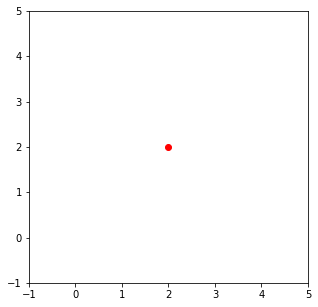

In [6]:
beta = 0.5
gamma = 0.5
grid1 = Grid(5,5, beta)

agent1 = Agent(State.infected, 0, 0, 1, gamma, grid1)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

def init():
  for agent in agent_list:
    A1 = ax.scatter(agent1.current_y, agent1.current_x, c=str(agent1.get_state()))
  return A1

def animate(i):
  ax.clear()
  axes = plt.gca()
  axes.set_xlim([-1,5])
  axes.set_ylim([-1,5])
  agent1.move()
  A1 = ax.scatter(agent1.current_y, agent1.current_x, c=str(agent1.get_state()))
  return A1

ani = animation.FuncAnimation(fig, animate, 
                frames=10, interval=1000, repeat=False, blit=False)
rc('animation', html='jshtml')
ani

# Q1. b) Random walk for several agents

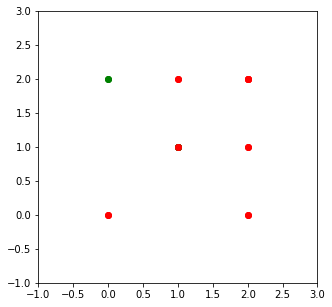

In [7]:
beta = 1
gamma = 0.0005
grid1 = Grid(3, 3, beta)
move_prob = 1
n_agents = 10


def populate_grid_with_agents(gamma, move_prob, grid, n_agents):
  states = [State.infected, State.recovered, State.susceptible]
  agent_list = []
  for i in range(n_agents):
    x_rand = random.randint(0, grid.x - 1)
    y_rand = random.randint(0, grid.y - 1)
    state_rand = random.choice(states)
    agent = Agent(state_rand, x_rand, y_rand, move_prob, gamma, grid)
    agent_list.append(agent)
  return agent_list


def move_agents_one_step(agent_list, grid):
  for agent in agent_list:
    agent.move()
  grid.recover_all_agents()


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
scatter_output_list = []
agent_list = populate_grid_with_agents(gamma, move_prob, grid1, n_agents)


def init():
  for agent in agent_list:
    scatter_output_list.append(ax.scatter(agent.current_y, agent.current_x, c=str(agent)))
  return scatter_output_list


def animate(i):
  ax.clear()
  axes = plt.gca()
  axes.set_xlim([-1, grid1.x])
  axes.set_ylim([-1, grid1.y])
  move_agents_one_step(agent_list, grid1)

  # print(grid1.get_number_of_agents_in_state(grid1.grid_infected))
  # print(grid1.get_number_of_agents_in_state(grid1.grid_susceptible))

  for agent in agent_list:
    scatter_output_list.append(ax.scatter(agent.current_y, agent.current_x, c=str(agent)))

  return scatter_output_list


ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=10, interval=1000, repeat=False, blit=False)
rc('animation', html='jshtml')
ani



# Q1. c) Random walk for several agents

TODO: initialize with prob state_rand = choice(states, 1, p=[0.4,0.6])

KeyboardInterrupt: ignored

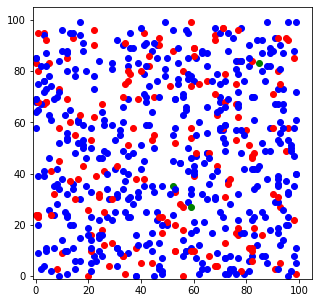

In [8]:
beta = 0.6
gamma = 0.01
grid1 = Grid(100, 100, beta)
move_prob = 0.8
n_agents = 1000
n_iteration = 1000


def populate_grid_with_agents(gamma, move_prob, grid, n_agents):
  states = [State.susceptible, State.infected, State.recovered]
  agent_list = []
  states_list = choice(states, 1000, p=[0.8, 0.2, 0])
  for i in range(n_agents):
    x_rand = random.randint(0, grid.x - 1)
    y_rand = random.randint(0, grid.y - 1)
    #state_rand = random.choice(states)
    #state_rand = choice(states, 1, p=[0.4,0.6])
    agent = Agent(states_list[i], x_rand, y_rand, move_prob, gamma, grid)
    agent_list.append(agent)
  return agent_list


def move_agents_one_step(agent_list, grid):
  for agent in agent_list:
    agent.move()
  grid.recover_all_agents()


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
scatter_output_list = []
infected_state_distribution_list = []
susceptible_state_distribution_list = []
recovered_state_distribution_list = []
n_infected_agents = 0
n_recovered_agents = 0
n_susceptible_agents = 0
agent_list = populate_grid_with_agents(gamma, move_prob, grid1, n_agents)


def init():
  for agent in agent_list:
    scatter_output_list.append(ax.scatter(agent.current_y, agent.current_x, c=str(agent)))
  return scatter_output_list


def animate(i):
  ax.clear()
  axes = plt.gca()
  axes.set_xlim([-1, 105])
  axes.set_ylim([-1, 105])
  move_agents_one_step(agent_list, grid1)
  n_infected_agents = grid1.get_number_of_infected_agents()
  n_susceptible_agents = grid1.get_number_of_susceptible_agents()
  n_recovered_agents = grid1.get_number_of_recovered_agents(n_agents, n_infected_agents, n_susceptible_agents)
  infected_state_distribution_list.append(n_infected_agents)
  recovered_state_distribution_list.append(n_recovered_agents)
  susceptible_state_distribution_list.append(n_susceptible_agents)

  for agent in agent_list:
    scatter_output_list.append(ax.scatter(agent.current_y, agent.current_x, c=str(agent)))

  return scatter_output_list


ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=n_iteration, interval=1000, repeat=False, blit=False)
rc('animation', html='jshtml')
ani




In [86]:
beta = 0.6
gamma = 0.01
grid1 = Grid(100, 100, beta)
move_prob = 0.8
n_agents = 1000
n_iterations = 1000

In [87]:
def populate_grid_with_agents(gamma, move_prob, grid, n_agents):
  states = [State.susceptible, State.infected, State.recovered]
  agent_list = []
  states_list = choice(states, 1000, p=[0.9, 0.1, 0])
  for i in range(n_agents):
    x_rand = random.randint(0, grid.x - 1)
    y_rand = random.randint(0, grid.y - 1)
    agent = Agent(states_list[i], x_rand, y_rand, move_prob, gamma, grid)
    agent_list.append(agent)
  return agent_list


def move_agents_one_step(agent_list, grid):
  for agent in agent_list:
    agent.move()
  grid.recover_all_agents()

In [88]:
def iterate_scatter_plot(n_iterations, grid):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111)
  agent_x_list = []
  agent_y_list = []
  agent_color_list = []
  agent_list = populate_grid_with_agents(gamma, move_prob, grid1, n_agents)

  for time_step in range(n_iterations):
    move_agents_one_step(agent_list, grid)

  for agent in agent_list:
      agent_x_list.append(agent.current_x)
      agent_y_list.append(agent.current_y)
      agent_color_list.append(str(agent))

  ax.scatter(agent_y_list, agent_x_list, c=agent_color_list, alpha=0.8, s=5)
  ax.set_title('t=100')

In [92]:
def iterate_n_agents(n_iterations):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111)
  infected_state_distribution_list = []
  susceptible_state_distribution_list = []
  recovered_state_distribution_list = []
  n_infected_agents = 0
  n_recovered_agents = 0
  n_susceptible_agents = 0
  agent_list = populate_grid_with_agents(gamma, move_prob, grid1, n_agents)

  for time_step in range(n_iterations):
    move_agents_one_step(agent_list, grid1)
    n_infected_agents = grid1.get_number_of_infected_agents()
    n_susceptible_agents = grid1.get_number_of_susceptible_agents()
    n_recovered_agents = grid1.get_number_of_recovered_agents(n_agents, n_infected_agents, n_susceptible_agents)
    infected_state_distribution_list.append(n_infected_agents)
    recovered_state_distribution_list.append(n_recovered_agents)
    susceptible_state_distribution_list.append(n_susceptible_agents)
  sns.lineplot(data=[susceptible_state_distribution_list, infected_state_distribution_list, recovered_state_distribution_list], ax=ax).set_title('d=0.8, beta=0.6, gamma=0.01')
  ax.legend(['Susceptible', 'Infected', 'Recovered'])
  plt.show()
  

# Plot at time step 100 for 1000 agents 

Parameters initialized: beta=0.6, gamma= 0.01 and diffusion = 0.8 

Initialization probability is 0.9 for susceptible, 0.1 for infected 


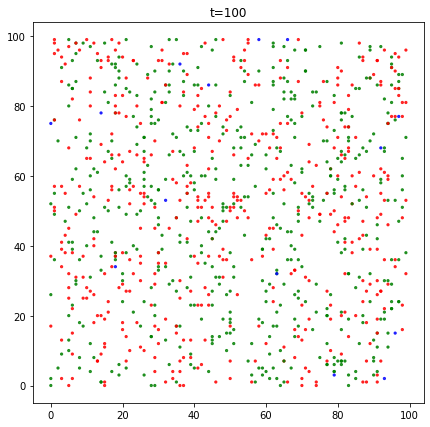

In [61]:
iterate_scatter_plot(100, grid1)

# Plot with state of agents over time

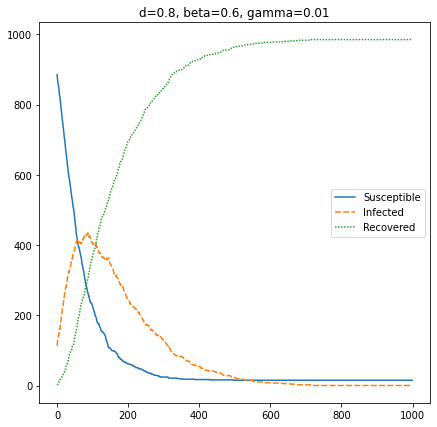

In [93]:
iterate_n_agents(n_iterations)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))

line, = ax.plot([], [])

def init():
    for agent in agent_list:
      scatter_output_list.append(ax.scatter(agent.current_y, agent.current_x, c=str(agent)))
    return scatter_output_list

def animate(i):
    move_agents_one_step(agent_list)
    plot_output_list = []

    for j in range(len(agent_list)):
      plot_output_list.append(j)

    x = np.linspace(0, 2, 1000)
    y = plot_output_list
#    y -= y % 0.3
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
anim


Q1. c) Simulation for 100X100 grid with 1000 agents


# TODO: FIX THIS 

Comment from student about init: 
I found that if the infection is randomly distributed, it reaches a larger part of the population, which makes sense. Left one or right one? I got the right graph very closely from setting the initial I to around 15%

From Mattias Ulmestrand to Everyone: (11:23 AM)
 I made a list of the indices closest to the middle in Euclidean distance and initialised the infected ones as those with the indices. That reproduced the graph in the pdf very well 
From Martin Hansson to Everyone: (11:23 AM)
 The right one I got correct but it was not focused to the middle if I start randomly (which make sense) So basically either way would be fine since we dont need to reproduce the exact behavior


In [ ]:
beta = 0.5
gamma = 0
grid1 = Grid(5,5, beta)
move_prob = 0.8
n_agents = 1000

def populate_grid_with_agents(gamma, move_prob, grid, n_agents):
  agent_list = []
  states = [State.infected, State.recovered, State.susceptible]
  for i in range(n_agents):
    x_rand = random.randint(0,grid.x-1)
    y_rand = random.randint(0, grid.y-1)
    state_rand = random.choice(states)
    agent = Agent(state_rand, x_rand, y_rand, move_prob, gamma, grid)
    agent_list.append(agent)
  return agent_list

def move_agents_one_step(agent_list):
  for agent in agent_list:
    agent.move()
  

fig = plt.figure(figsize=(100, 100))
ax = fig.add_subplot(111)
agent_list = populate_grid_with_agents(gamma, move_prob, grid1, n_agents)

# TODO: init??

def animate():
  ax.clear()
  axes = plt.gca()
  axes.set_xlim([-1,5])
  axes.set_ylim([-1,5])
  move_agents_one_step(agent_list)

  for agent in agent_list:
    ax.scatter(agent.current_y, agent.current_x, c=str(agent))
    

animate()
plt.show()





In [ ]:
!python --version

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()


ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially  
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=100, interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim
  